In [1]:
import biom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gemelli.joint_ctf import joint_ctf
from gemelli.simulations import build_block_model

fig_path = '/Users/bec5786/Desktop/temp_figs/'
%matplotlib inline
data_path = '../ipynb/tutorials/'

In [84]:
def create_sim_data(feature_prefix, n_timepoints, n_subjects,
                    rank=3, hoced=20, hsced=20, 
                    spar=2e3, C_=2e3, overlap=0,
                    num_samples=48, num_features=500):
    
    #create simulated data
    total_samples = n_timepoints * n_subjects
    test_true, test_noise = build_block_model(rank=rank, 
                                              hoced=hoced, hsced=hsced, 
                                              spar=spar, C_=C_, 
                                              num_samples=num_samples,
                                              num_features=num_features,
                                              overlap=overlap, 
                                              mapping_on=False)
    #add feature and sample IDs
    feat_ids = [ '%sF%d' % (feature_prefix, i+1)
                for i in range(test_noise.shape[0])]
    samp_ids = ['sample%d' % (i+1) for i in range(test_noise.shape[1])]
    test_noise = biom.Table(test_noise, feat_ids, samp_ids)
    test_true = biom.Table(test_true, feat_ids, samp_ids)
    
    #create metadata
    mf = pd.DataFrame({'timepoint': np.tile(np.arange(n_timepoints), n_subjects)},
                      index=samp_ids)
    ind_ids = [['ind{}'.format(i+1)] * n_timepoints for i in range(n_subjects)]
    ind_ids = np.concatenate(ind_ids)
    mf['ind_id'] = ind_ids
    #add group ids based on rank
    group_ids = []
    for i in range(rank):
        group_ids.extend(['group{}'.format(i+1)] * (total_samples//rank))
    mf['group'] = group_ids

    return test_true, test_noise, mf

In [85]:
true_mod1, noise_mod1, mf_mod1 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=2e3)
true_mod2, noise_mod2, mf_mod2 = create_sim_data('mod2', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=1e3)

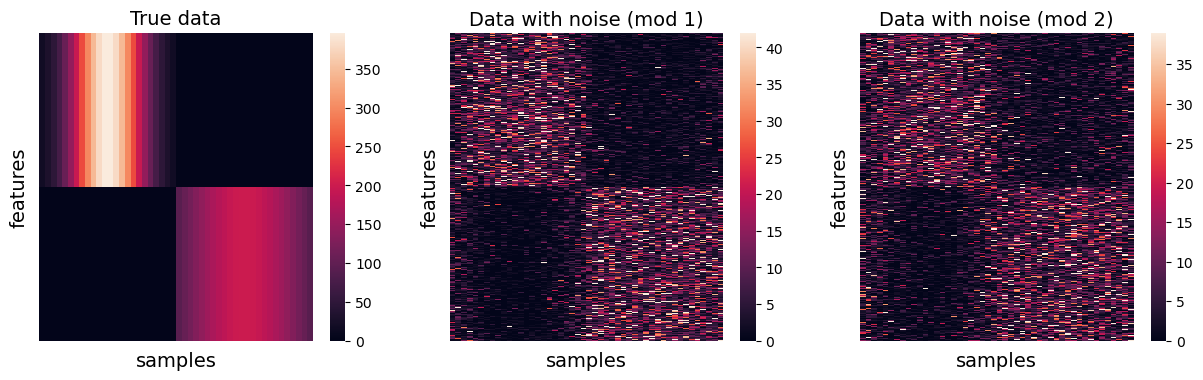

In [86]:
# plot data
fig, axn = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(true_mod1.matrix_data.toarray(), robust=True, 
            ax=axn[0], xticklabels=False, yticklabels=False)
sns.heatmap(noise_mod1.matrix_data.toarray(), robust=True, 
            ax=axn[1], xticklabels=False, yticklabels=False)
sns.heatmap(noise_mod2.matrix_data.toarray(), robust=True, 
            ax=axn[2], xticklabels=False, yticklabels=False)
axn[0].set_ylabel('features', color='black', fontsize=14)
axn[0].set_xlabel('samples', color='black', fontsize=14)
axn[0].set_title('True data', color='black', fontsize=14)
axn[1].set_ylabel('features', color='black', fontsize=14)
axn[1].set_xlabel('samples', color='black', fontsize=14)
axn[1].set_title('Data with noise (mod 1)', color='black', fontsize=14)
axn[2].set_ylabel('features', color='black', fontsize=14)
axn[2].set_xlabel('samples', color='black', fontsize=14)
axn[2].set_title('Data with noise (mod 2)', color='black', fontsize=14)
#plt.savefig('{}{}_sim_data_heatmap.png'.format(fig_path, C_mod2),
#            bbox_inches='tight')
plt.show()

In [81]:
#run joint-ctf
(subject_loads, feature_loads, state_loads,
evals, var_explained, feature_covs) = joint_ctf(tables=[noise_mod1, noise_mod2],
                                                sample_metadatas=[mf_mod1, mf_mod2],
                                                modality_ids=['mod1', 'mod2'],
                                                individual_id_column='ind_id',
                                                state_column='timepoint')
print(evals)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 7 iterations
Calculate components for component_2
Reached convergence in 21 iterations
Calculate components for component_3
Reached convergence in 21 iterations
      component_1  component_2  component_3
mod1  3821.388748   819.767887  1037.363418
mod2  3239.370287  1642.685685  2696.076836
               component_1  component_2  component_3
var_explained     0.530455     0.291247     0.178298


In [87]:
#run joint-ctf
(true_subject_loads, true_feature_loads, 
true_state_loads, true_evals,
true_var_explained, true_feature_covs) = joint_ctf(tables=[true_mod1],
                                                   sample_metadatas=[mf_mod1],
                                                   modality_ids=['mod0'],
                                                   individual_id_column='ind_id',
                                                   state_column='timepoint')
print(true_evals)
print(true_var_explained.T)

Calculate components for component_1
Reached convergence in 2 iterations
Calculate components for component_2
Reached convergence in 4 iterations
Calculate components for component_3
Reached convergence in 4 iterations
       component_1  component_2  component_3
mod0  61829.015512  11941.44944   3507.33426
               component_1  component_2  component_3
var_explained     0.999864     0.000094     0.000042


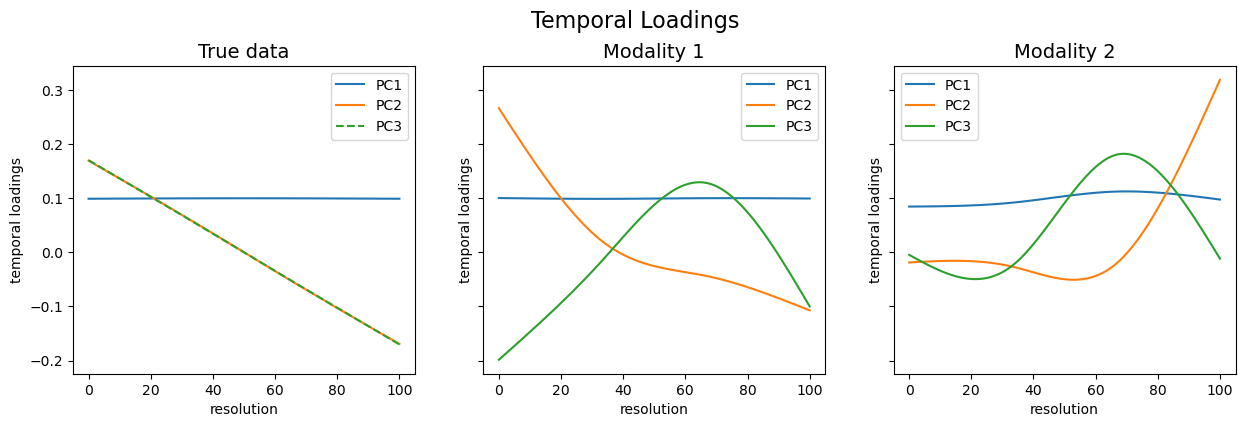

In [88]:
#temporal loadings
fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for component,label,ls in zip(['component_1', 'component_2', 'component_3'],
                            ['PC1', 'PC2', 'PC3'], ['-', '-', '--']):
    axn[0].plot(true_state_loads['mod0'][component], 
                label=label, linestyle=ls)
axn[0].legend()
axn[0].set_title('True data', fontsize=14)
axn[1].plot(state_loads['mod1'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[1].legend()
axn[1].set_title('Modality 1', fontsize=14)
axn[2].plot(state_loads['mod2'][['component_1', 'component_2', 'component_3']],
            label=['PC1', 'PC2', 'PC3'])
axn[2].legend()
axn[2].set_title('Modality 2', fontsize=14)
plt.suptitle('Temporal Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel='resolution', ylabel='temporal loadings')
plt.show()

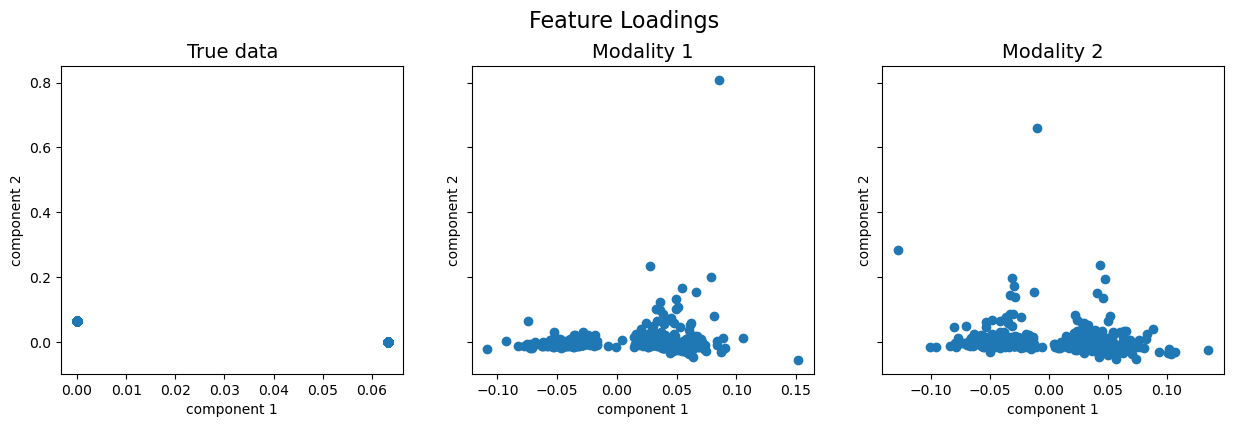

In [71]:
#feature loadings
comp1 = 'component_1'
comp2 = 'component_2'

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axn[0].scatter(true_feature_loads['mod0'][comp1],
               true_feature_loads['mod0'][comp2])
axn[0].set_title('True data', fontsize=14)
axn[1].scatter(feature_loads['mod1'][comp1],
               feature_loads['mod1'][comp2])
axn[1].set_title('Modality 1', fontsize=14)
axn[2].scatter(feature_loads['mod2'][comp1],
               feature_loads['mod2'][comp2])
axn[2].set_title('Modality 2', fontsize=14)
plt.suptitle('Feature Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

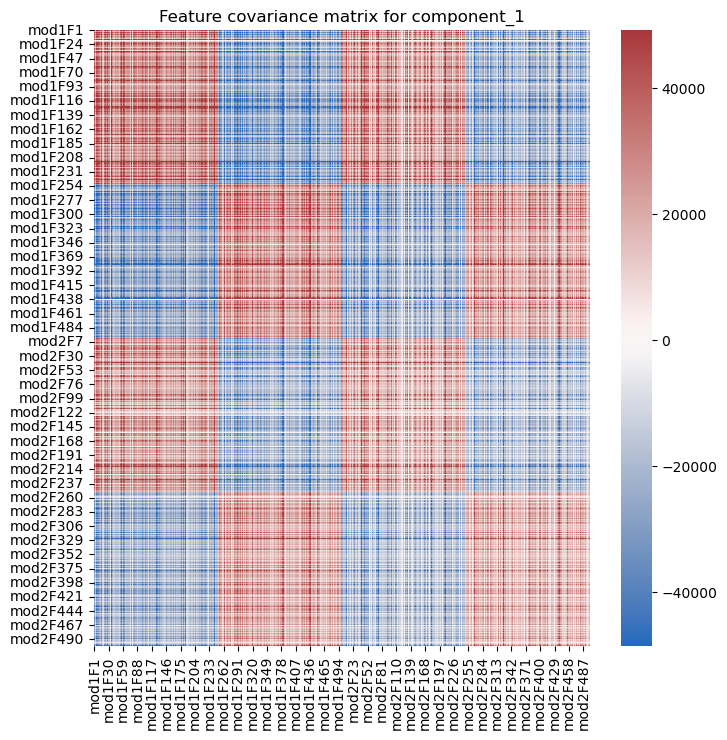

In [62]:
#get feature cov matrix and reorder IDs
feature_order1 = noise_mod1.ids(axis='observation').tolist()
feature_order2 = noise_mod2.ids(axis='observation').tolist()
feature_order = feature_order1 + feature_order2

component = 'component_1'
cov_table = feature_covs[component]
cov_table = cov_table.loc[feature_order, feature_order]

#plot heatmap of feature covariance matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cov_table, robust=True, cmap='vlag')
plt.title('Feature covariance matrix for {}'.format(component))
plt.show()

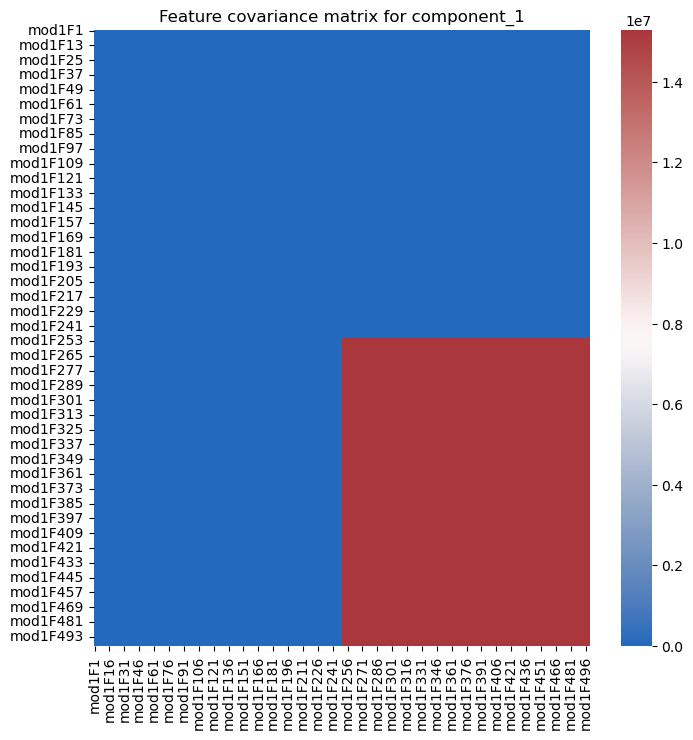

In [69]:
true_order = true_mod1.ids(axis='observation').tolist()
true_cov_table = true_feature_covs[component]
true_cov_table = true_cov_table.loc[true_order, true_order]

plt.figure(figsize=(8, 8))
sns.heatmap(true_cov_table, robust=True, cmap='vlag')
plt.title('Feature covariance matrix for {}'.format(component))
plt.show()

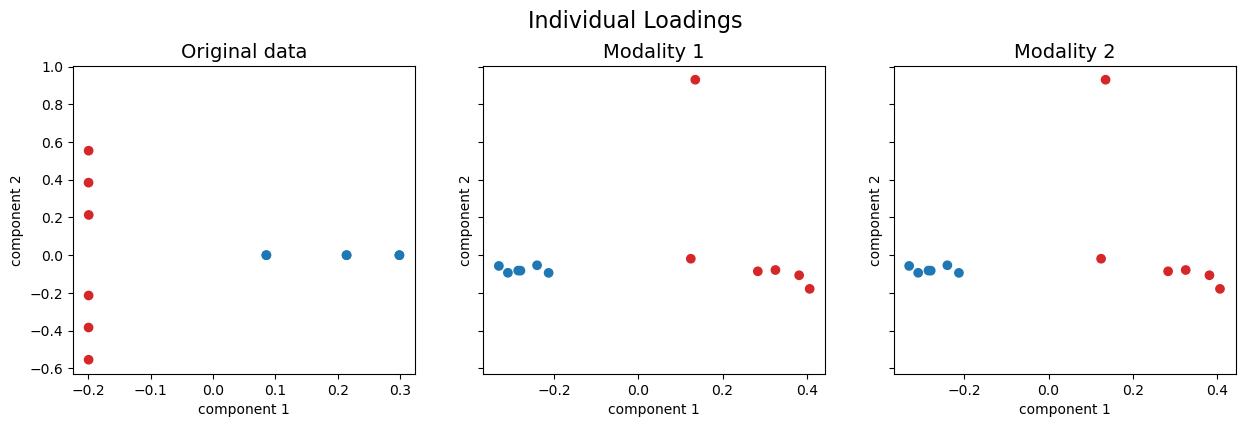

In [60]:
#feature loadings
comp1 = 'component_1'
comp2 = 'component_2'
mf1 = mf_mod1.groupby('ind_id').agg({'group':'first'})
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axn[0].scatter(true_subject_loads['mod0'][comp1],
               true_subject_loads['mod0'][comp2],
               c=mf1['group'].map(group_colors))
axn[0].set_title('Original data', fontsize=14)
axn[1].scatter(subject_loads['mod1'][comp1],
               subject_loads['mod1'][comp2],
               c=mf1['group'].map(group_colors))
axn[1].set_title('Modality 1', fontsize=14)
axn[2].scatter(subject_loads['mod2'][comp1],
               subject_loads['mod2'][comp2],
               c=mf1['group'].map(group_colors))
axn[2].set_title('Modality 2', fontsize=14)
plt.suptitle('Individual Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()